In [48]:
import os
from dotenv import load_dotenv
load_dotenv()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import seaborn as sns
from tld import get_tld

In [45]:
from pymongo import MongoClient, ASCENDING
import numpy as np

MONGO_PASSWORD = os.environ['MONGO_USER_PASSWORD']
CROWD_TANGLE = os.environ['CROWD_TANGLE_API_TOKEN']

config = {
  'host': '18.216.52.13:27017',
  'username': 'mongo_user',
  'password': MONGO_PASSWORD,
  'authSource': 'reddit_climate_news'
}

db = MongoClient(**config).reddit_climate_news

In [46]:
pd.set_option('display.max_rows', 102)

# Score Distribution

## With Climate Query

In [53]:
posts_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'score': 1}))

In [58]:
posts_df[posts_df.score == 1].shape[0] / posts_df.shape[0]

0.9074155331285652

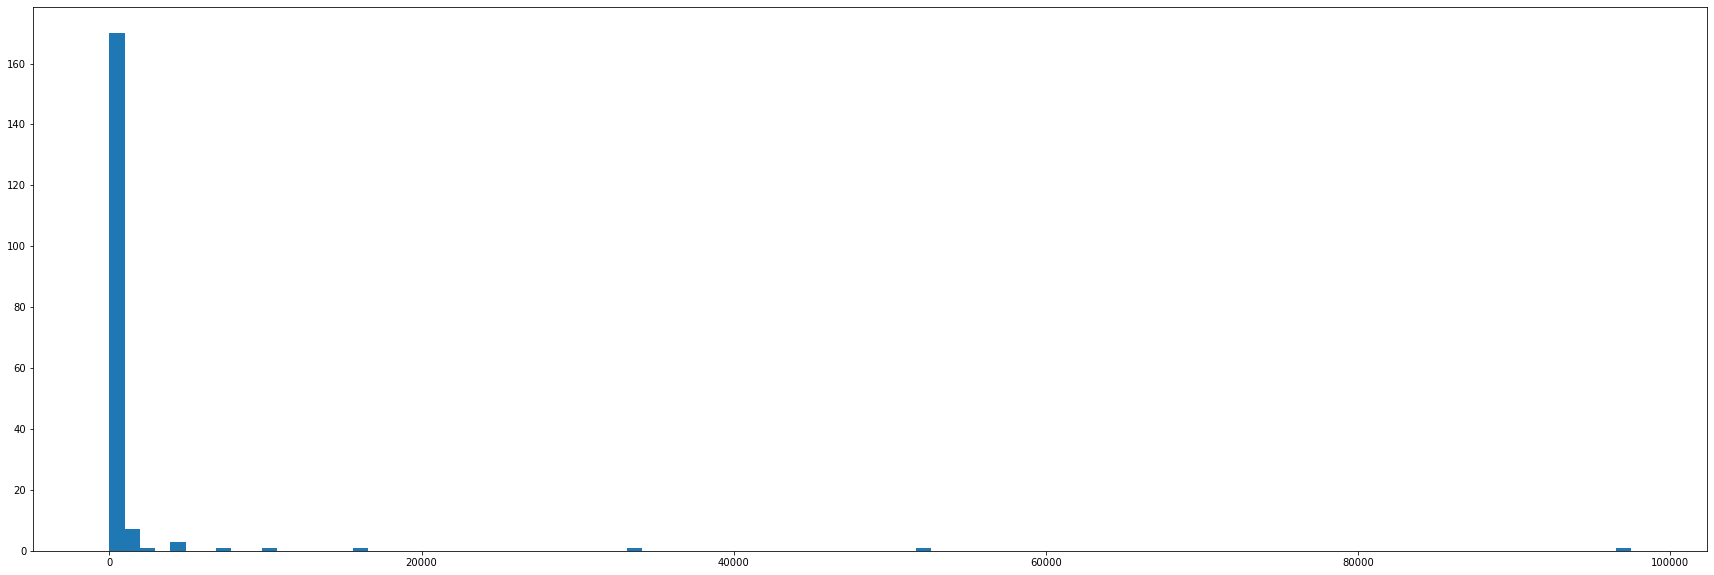

In [69]:
plt.figure(figsize=(30, 10))
plt.hist(posts_df[posts_df.score > 1].score, bins=100);

## All Submissions

In [83]:
all_posts_df = pd.DataFrame.from_records(db.submissions.find({}, {'score': 1}))

In [84]:
all_posts_df[all_posts_df.score == 1].shape[0] / all_posts_df.shape[0]

0.9530127050737688

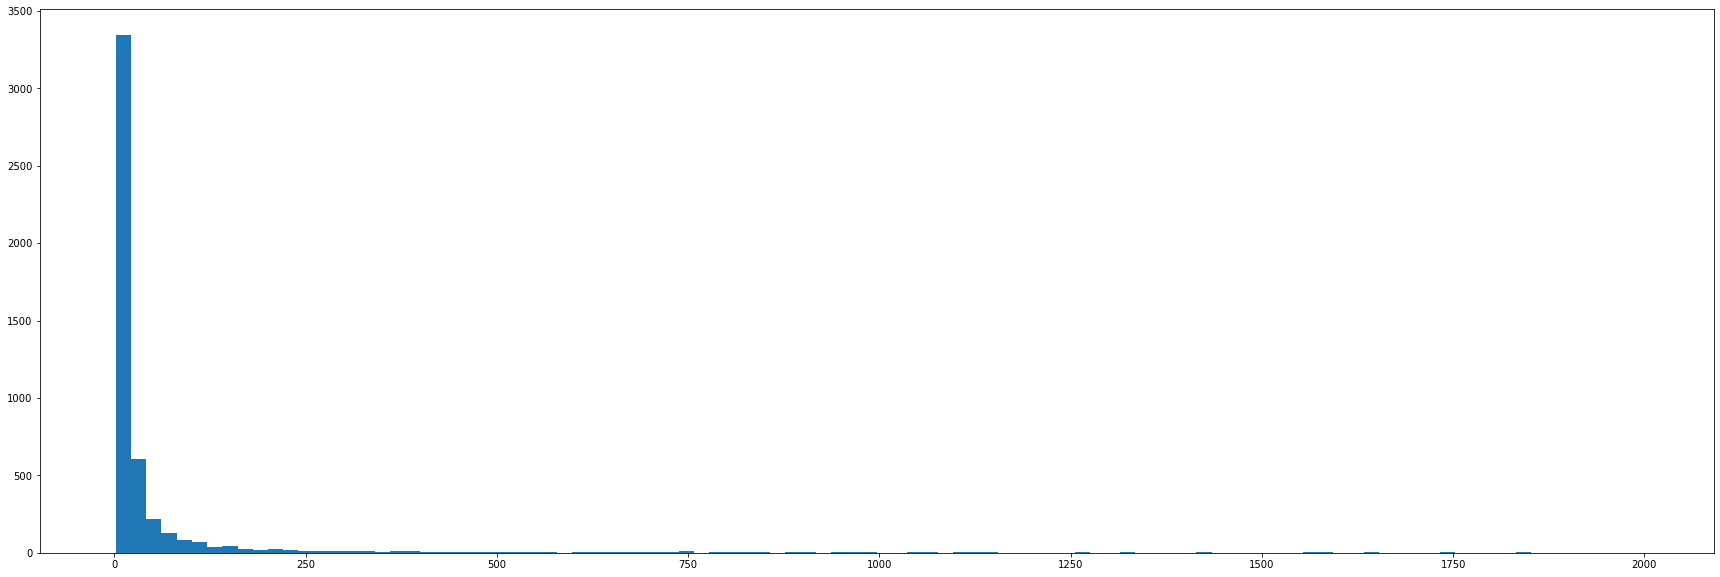

In [88]:
plt.figure(figsize=(30, 10))
plt.hist(all_posts_df[(all_posts_df.score > 1) & (all_posts_df.score < 2000)].score, bins=100);

**Score might be a bad dependent variable**

What if I did number of comments instead?

# Number of Comments

## With Climate Query

In [72]:
num_comm_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'num_comments': 1}))

In [73]:
num_comm_df.describe()

,num_comments
count,2279.000000
mean,85.949978
std,412.053399
min,0.000000
25%,1.000000
50%,4.000000
75%,16.500000
max,6466.000000


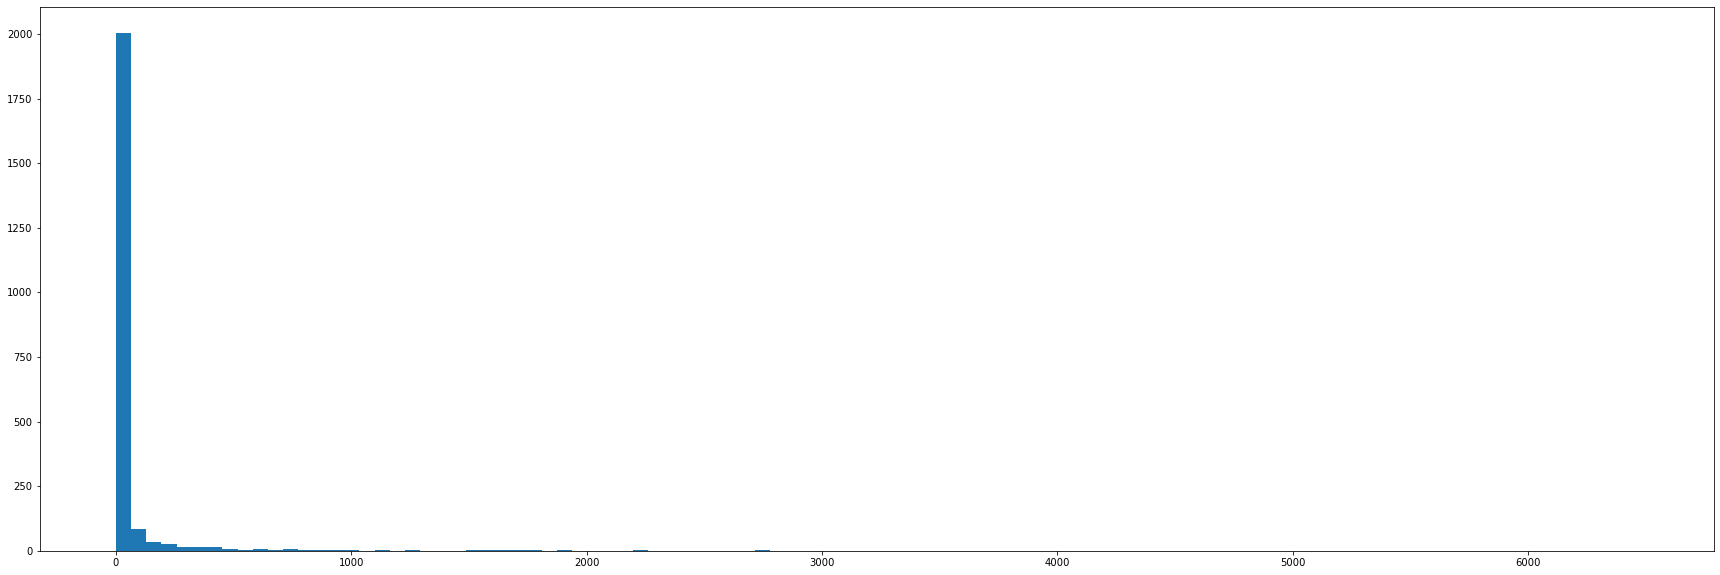

In [75]:
plt.figure(figsize=(30, 10))
plt.hist(num_comm_df.num_comments, bins=100);

## All Submissions

In [89]:
all_comm_df = pd.DataFrame.from_records(db.submissions.find({}, {'num_comments': 1}))

In [90]:
all_comm_df.describe()

,num_comments
count,121054.000000
mean,38.026831
std,406.154310
min,0.000000
25%,0.000000
50%,1.000000
75%,5.000000
max,44762.000000


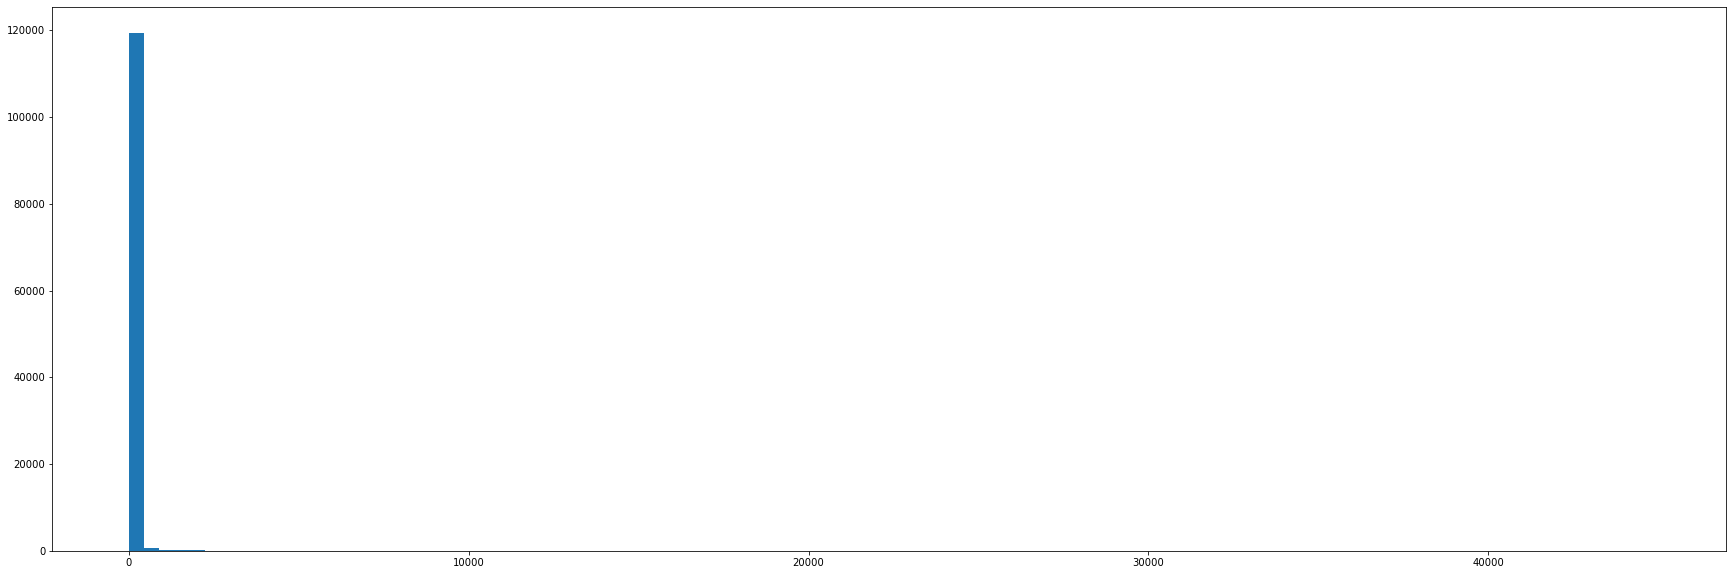

In [91]:
plt.figure(figsize=(30, 10))
plt.hist(all_comm_df.num_comments, bins=100);

In [181]:
both_df = pd.DataFrame.from_records(db.submissions.find({}, {'num_comments': 1, 'score': 1}))

In [183]:
both_df.corr()

,num_comments,score
num_comments,1.000000,0.291983
score,0.291983,1.000000


In [200]:
both_df[both_df.score > 1].corr()

,num_comments,score
num_comments,1.000000,0.594141
score,0.594141,1.000000


# How accurate was the q=climate query?

In [154]:
tr_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'text_razor.response.topics': 1, 'url': 1}))

In [143]:
np.sum(tr_df.text_razor.map(
    lambda tr: len(set(['Global warming', 'Climate change']).intersection(set([x['label'] for x in tr.get('response', {}).get('topics', [])]))) > 0,
    na_action='ignore'))
                                

650

In [ ]:
Greenhouse gas, Carbon dioxide, Climate change, Climate

In [157]:
tr_df.text_razor[0]['response']

{'topics': [{'id': 0,
   'label': 'Agriculture',
   'wikiLink': 'http://en.wikipedia.org/Agriculture',
   'score': 1,
   'wikidataId': 'Q11451'},
  {'id': 1,
   'label': 'Soil',
   'wikiLink': 'http://en.wikipedia.org/Soil',
   'score': 1,
   'wikidataId': 'Q36133'},
  {'id': 2,
   'label': 'Cattle',
   'wikiLink': 'http://en.wikipedia.org/Cattle',
   'score': 1,
   'wikidataId': 'Q830'},
  {'id': 3,
   'label': 'Primary sector of the economy',
   'wikiLink': 'http://en.wikipedia.org/Category:Primary_sector_of_the_economy',
   'score': 1,
   'wikidataId': 'Q55640'},
  {'id': 4,
   'label': 'Natural resources',
   'wikiLink': 'http://en.wikipedia.org/Category:Natural_resources',
   'score': 1,
   'wikidataId': 'Q188460'},
  {'id': 5,
   'label': 'Primary industries',
   'wikiLink': 'http://en.wikipedia.org/Category:Primary_industries',
   'score': 1},
  {'id': 6,
   'label': 'Human activities',
   'wikiLink': 'http://en.wikipedia.org/Category:Human_activities',
   'score': 1},
  {'id': 

In [131]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2279 entries, 0 to 2278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   _id         2279 non-null   object
 1   text_razor  703 non-null    object
dtypes: object(2)
memory usage: 35.7+ KB


In [144]:
650 / 703

0.9246088193456614

In [158]:
tr_df['max_topic_score'] = tr_df.text_razor.map(
    lambda tr: np.max([x['score'] for x in tr.get('response', {}).get('topics', []) if x['label'] in ['Climate change', 'Global warming']], initial=0),
    na_action='ignore')


In [166]:
for url in tr_df[tr_df.max_topic_score > 0].sort_values('max_topic_score').head(20).url:
    print(url)

https://www.abc.net.au/news/2020-01-23/has-australias-climate-switch-been-flicked/11885300?pfmredir=sm
https://www.bbc.com/news/world-africa-51242972
https://www.bbc.com/news/world-africa-51242972
https://www.bbc.co.uk/news/world-africa-51242972
https://www.theguardian.com/business/2020/jan/23/world-bank-chief-david-malpass-davos-snub-dashes-hopes-climate-crisis-consensus
https://www.france24.com/en/20200211-13-activists-held-in-paris-over-storming-of-blackrock-offices
https://www.theguardian.com/global-development/2020/jan/27/mogadishu-left-reeling-as-climate-and-conflict-spark-rural-exodus
https://www.nydailynews.com/news/national/ny-doomsday-clock-20200123-a4fuynnpkjadjih3vkn5eds5r4-story.html
https://africabusinesscommunities.com/agribusiness/news/southern-africa-in-throes-of-climate-emergency-45-million-people-facing-hunger-across-the-region-wfp/
https://www.rollingstone.com/politics/politics-news/trump-davos-speech-world-economic-forum-940280/
https://www.positive.news/society/ed

**Visual inspection confirms that the vast majority of the articles are about climate change even if the TextRazor score is low**

What about the 53 that TextRazor doesn't label either Global warming or Climate change?

In [170]:
for url in tr_df[~tr_df.text_razor.isnull() & (tr_df.max_topic_score == 0)].url:
    print(url)

https://www.thenation.com/article/greta-thunberg-climate-change-strike/
https://www.thenation.com/article/greta-thunberg-climate-change-strike/
https://www.thenation.com/article/greta-thunberg-climate-change-strike/
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt
https://www.msn.com/en-nz/news/world/world-leaders-accused-of-blindness-to-climate-change/ar-BBUixwr?li=BBSVbAt


**Visual inspection of the 53 suggests they are also about climate change**

So I can probably rely on the q=climate to get topically articles. So only need text razor if the granular topics are predictive of score/comments etc.

For now, can probably try to do the analysis without it

In [173]:
top_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'score': 1, 'url': 1, 'num_comments': 1}))

In [178]:
for url in top_df.sort_values('score', ascending=False).head(20).url:
    print(url)

https://www.independent.co.uk/environment/climate-emergency-scientists-emissions-letter-climate-change-a9185786.html
https://www.cnbc.com/2019/11/05/elizabeth-warren-slams-twitter-for-ban-on-ads-tied-to-climate-change.html
https://www.newsweek.com/trump-paris-climate-change-agreement-governors-republican-democrat-1469769
https://edition.cnn.com/2019/11/06/asia/new-zealand-ok-boomer-trnd/index.html
https://www.businessinsider.com/google-employees-are-demanding-the-company-cut-ties-with-climate-change-deniers-2019-11
https://www.reuters.com/article/us-climate-change-italy-exclusive/exclusive-italy-to-make-climate-change-study-compulsory-in-schools-idUSKBN1XF1E1?utm_source=reddit.com
https://www.washingtonpost.com/world/2019/11/01/australias-prime-minister-pledges-outlaw-climate-boycotts-arguing-they-threaten-economy/
https://www.cnbc.com/2020/01/02/amazon-threatens-to-fire-employees-who-speak-out-on-climate-change.html
https://news.yahoo.com/australia-pm-vows-outlaw-apocalyptic-climate-a

**Visual inspection of highest scoring articles confirms about climate change**

In [179]:
for url in top_df.sort_values('num_comments', ascending=False).head(20).url:
    print(url)

https://www.independent.co.uk/environment/climate-emergency-scientists-emissions-letter-climate-change-a9185786.html
https://www.independent.co.uk/environment/greta-thunberg-climate-change-rest-protest-trump-bolsonaro-turin-environment-a9246641.html
https://www.reuters.com/article/us-australia-wildfires-climate-change-an/scientists-paint-australia-fires-as-red-alert-on-climate-change-idUSKBN1ZB00Y?utm_source=reddit.com
https://www.independent.co.uk/environment/australia-heatwave-weather-forecast-warnings-climate-crisis-scott-morrison-a9248376.html?amp
https://www.vanityfair.com/news/2019/12/melania-trump-greta-thunberg
https://www.theglobeandmail.com/world/article-australias-leaders-unmoved-on-climate-action-after-devastating-2/
https://metro.co.uk/2019/11/30/sir-david-attenborough-says-late-reverse-climate-change-11244918/
https://www.reuters.com/article/us-climate-change-thunberg-idUSKBN1YY0PV
https://theweek.com/speedreads/888638/trump-now-says-climate-change-serious-not-hoax
https:

**Visual inspection of highest comment articles confirms about climate change**

# How many duplicate posts are there?

In [226]:
url_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'url': 1, 'id': 1, 'score': 1, 'num_comments': 1}))

In [211]:
url_counts = url_df.url.value_counts()

In [214]:
np.sum(url_counts[url_counts > 1]) - len(url_counts[url_counts > 1])

473

In [213]:
np.sum(url_counts)

2279

In [216]:
473 / 2279
# 20% of posts are duplicates -> I wonder if this skews results?

0.20754716981132076

In [229]:
url_counts = url_df[url_df.score > 1].url.value_counts()
np.sum(url_counts[url_counts > 1]) - len(url_counts[url_counts > 1])
# But very few duplicates have a score > 1

24

**If I take the highest of the duplicates according to metric, should be fine**

# How is distribution of dependent variables changed if I remove dups?

In [217]:
expl_drop_df = pd.DataFrame.from_records(db.climate_submissions.find({}, {'url': 1, 'id': 1, 'score': 1, 'num_comments': 1}))

In [232]:
dedup_df = expl_drop_df.sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

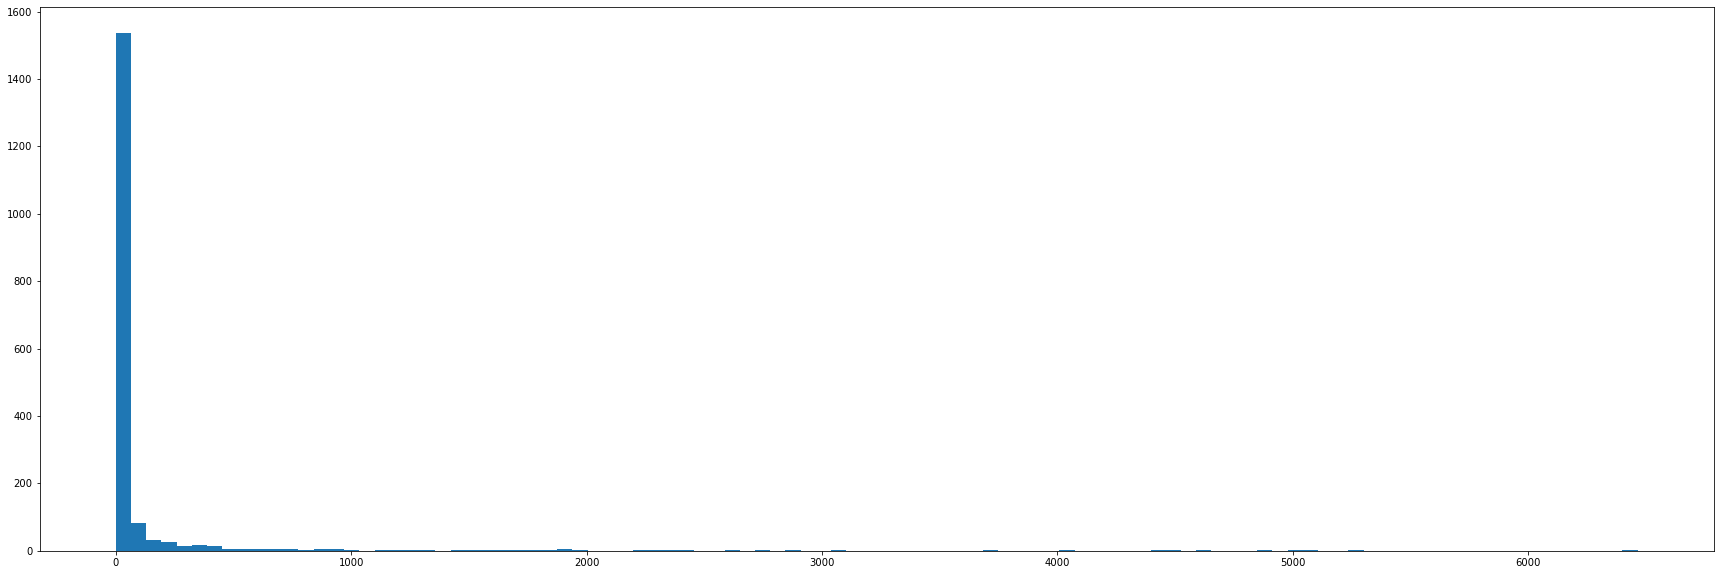

In [234]:
plt.figure(figsize=(30, 10))
plt.hist(dedup_df.num_comments, bins=100);

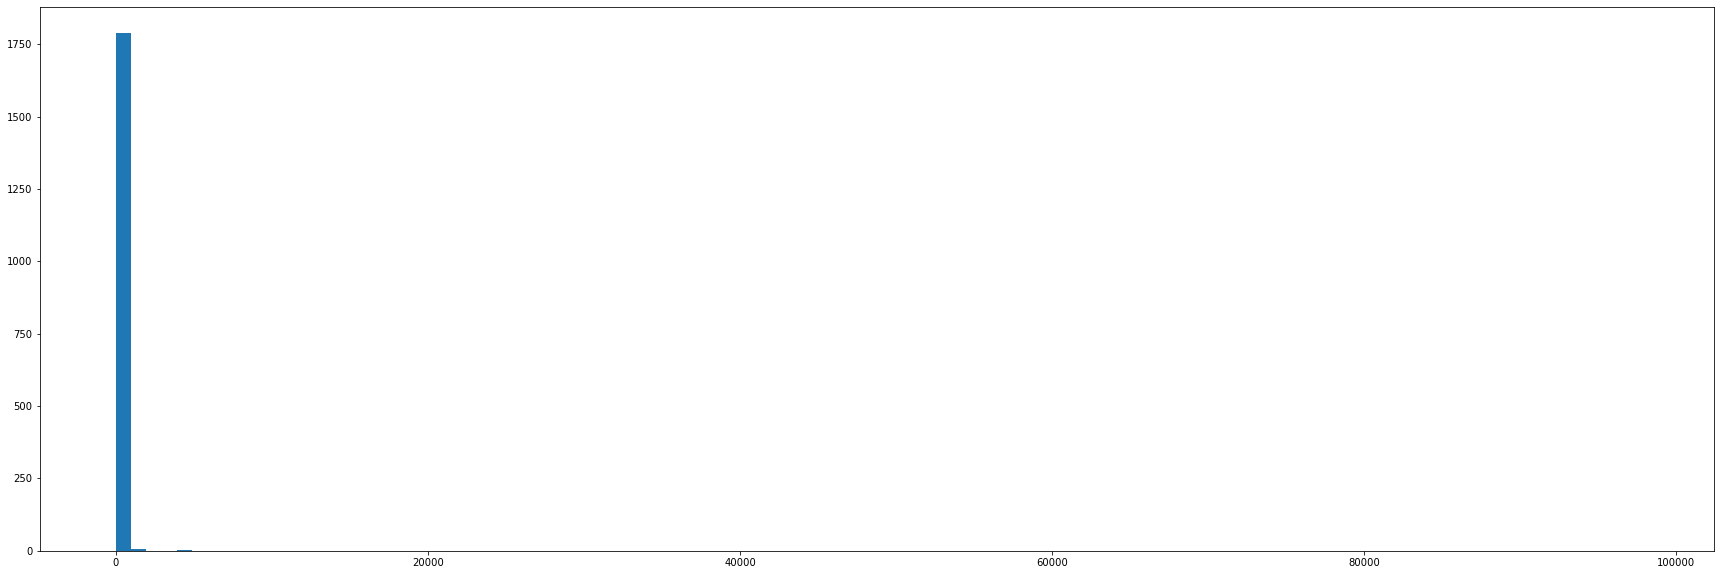

In [235]:
plt.figure(figsize=(30, 10))
plt.hist(dedup_df.score, bins=100);

**Slightly Improved (still kinda sucks)**

Num Comments seems like a slightly better explanatory variable

# Facebook Data

In [79]:
ct_records = [
    { **x['crowd_tangle']['result']['interactions'], 'id': x['id'], 'score': x['score'], 'url': x['url'], 'num_comments': x['num_comments']} for x
    in db.climate_submissions.find({'crowd_tangle.result': {'$exists': True}}, {'id': 1, 'score': 1, 'crowd_tangle': 1, 'url': 1, 'num_comments': 1})]


In [247]:
ct_df = pd.DataFrame.from_records(ct_records).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [249]:
ct_df.corr()

,facebookInteractionCount,reactionCount,commentCount,shareCount,score,num_comments
facebookInteractionCount,1.000000,0.995998,0.899643,0.938207,-0.001109,0.137733
reactionCount,0.995998,1.000000,0.865654,0.926151,-0.002621,0.131253
commentCount,0.899643,0.865654,1.000000,0.784293,0.001798,0.174350
shareCount,0.938207,0.926151,0.784293,1.000000,0.004155,0.101445
score,-0.001109,-0.002621,0.001798,0.004155,1.000000,0.035051
num_comments,0.137733,0.131253,0.174350,0.101445,0.035051,1.000000


**Some relationship between FB interaction and Reddit comments**

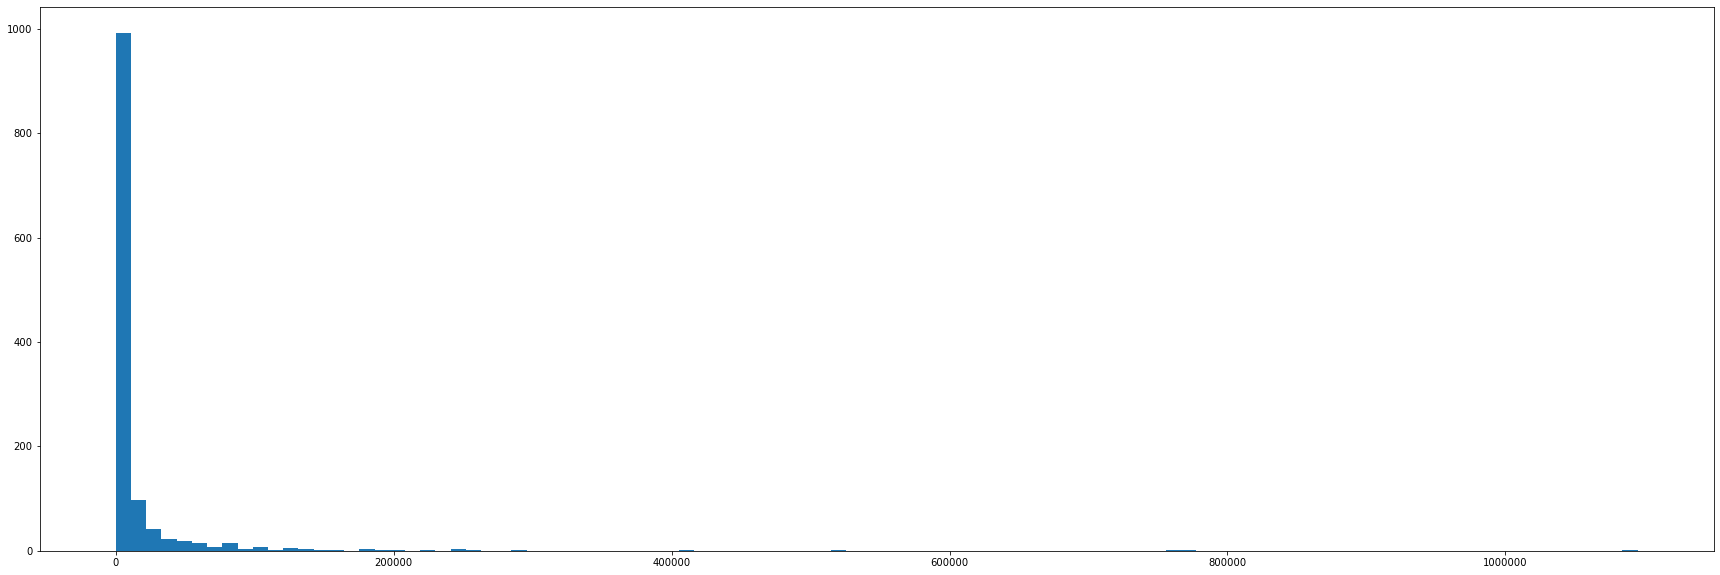

In [251]:
plt.figure(figsize=(30,10))
plt.hist(ct_df.facebookInteractionCount, bins=100);

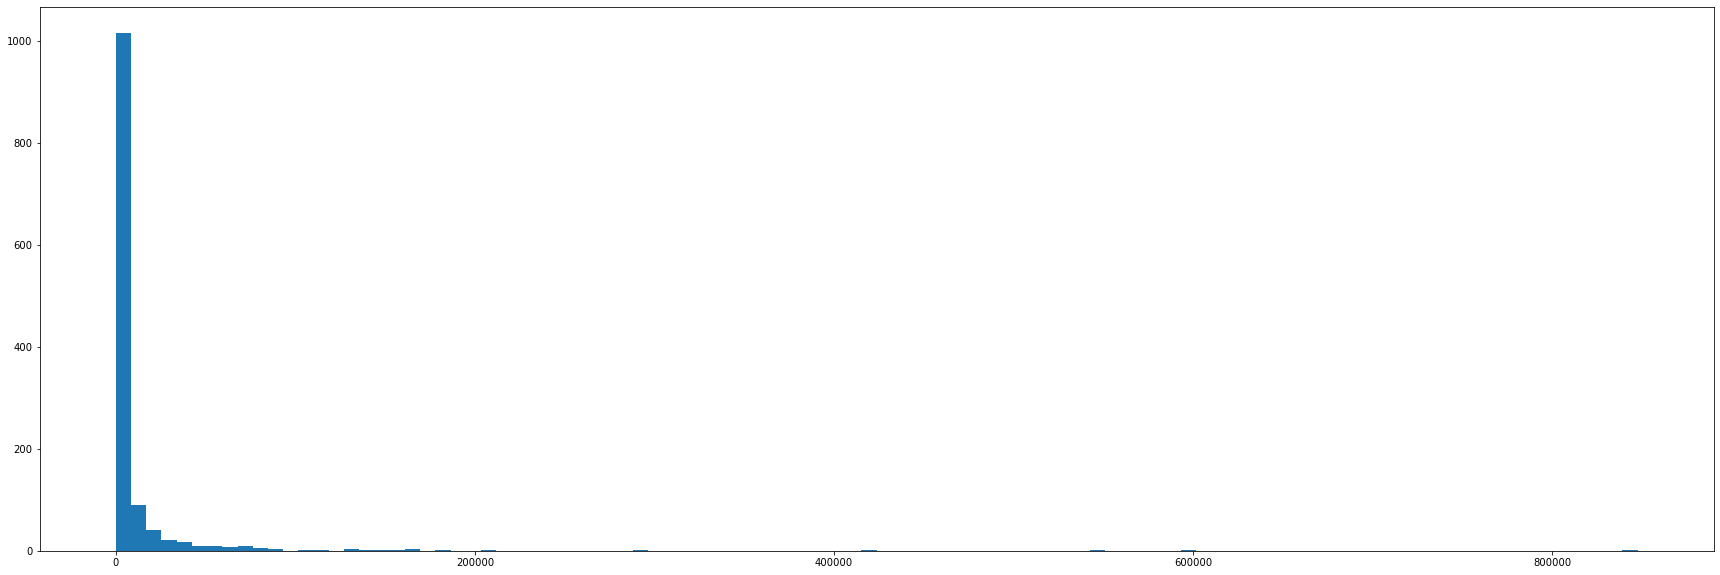

In [252]:
plt.figure(figsize=(30,10))
plt.hist(ct_df.reactionCount, bins=100);

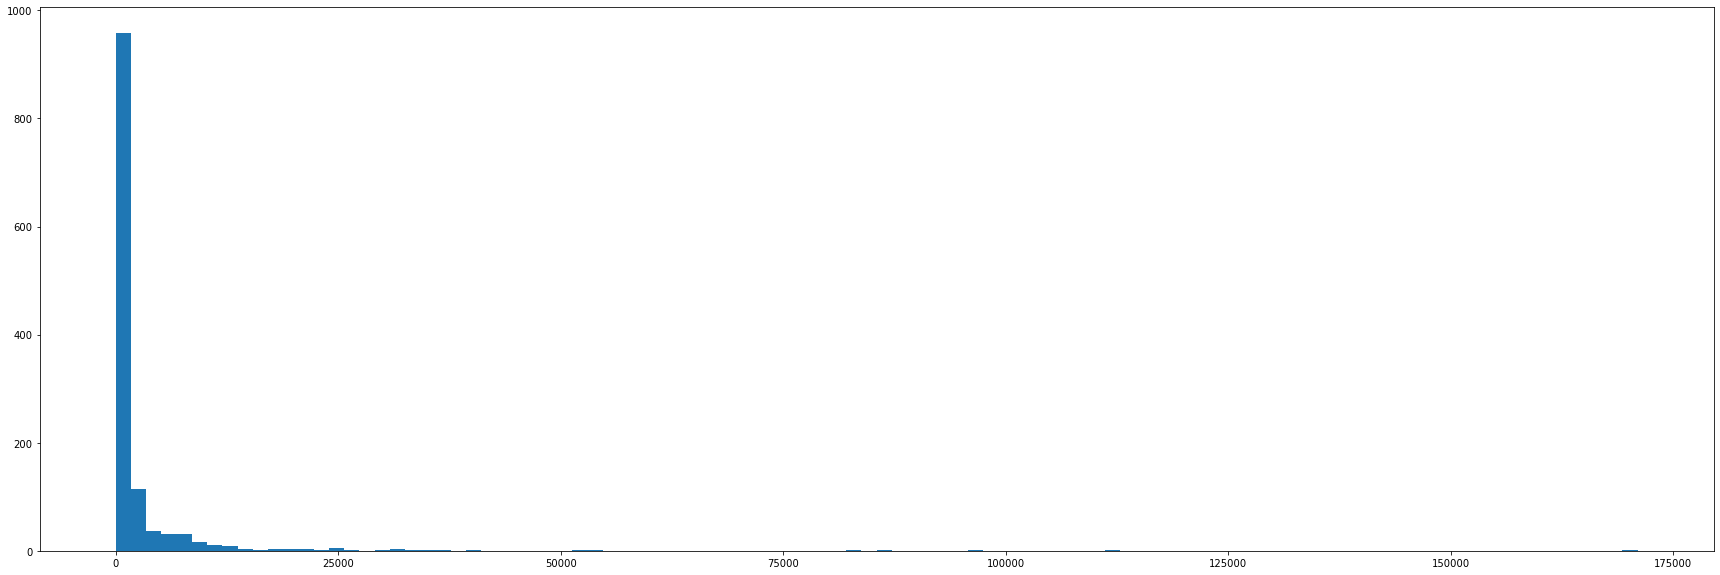

In [253]:
plt.figure(figsize=(30,10))
plt.hist(ct_df.commentCount, bins=100);

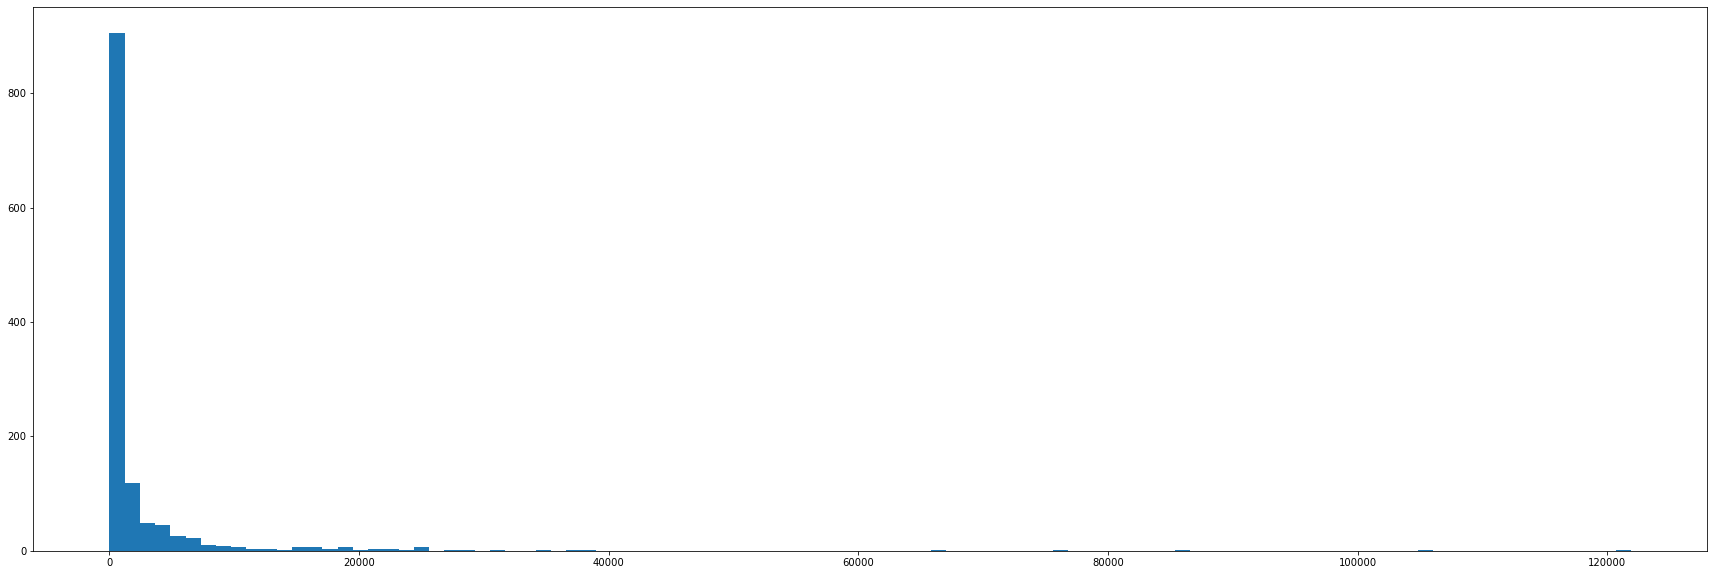

In [254]:
plt.figure(figsize=(30,10))
plt.hist(ct_df.shareCount, bins=100);

**Probably pick one FB metric (probably comments -> highest corr)**

# Sentiment and Tone

In [280]:
sent_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1, 'sentiment_score': 1, 'tone_analyzer': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

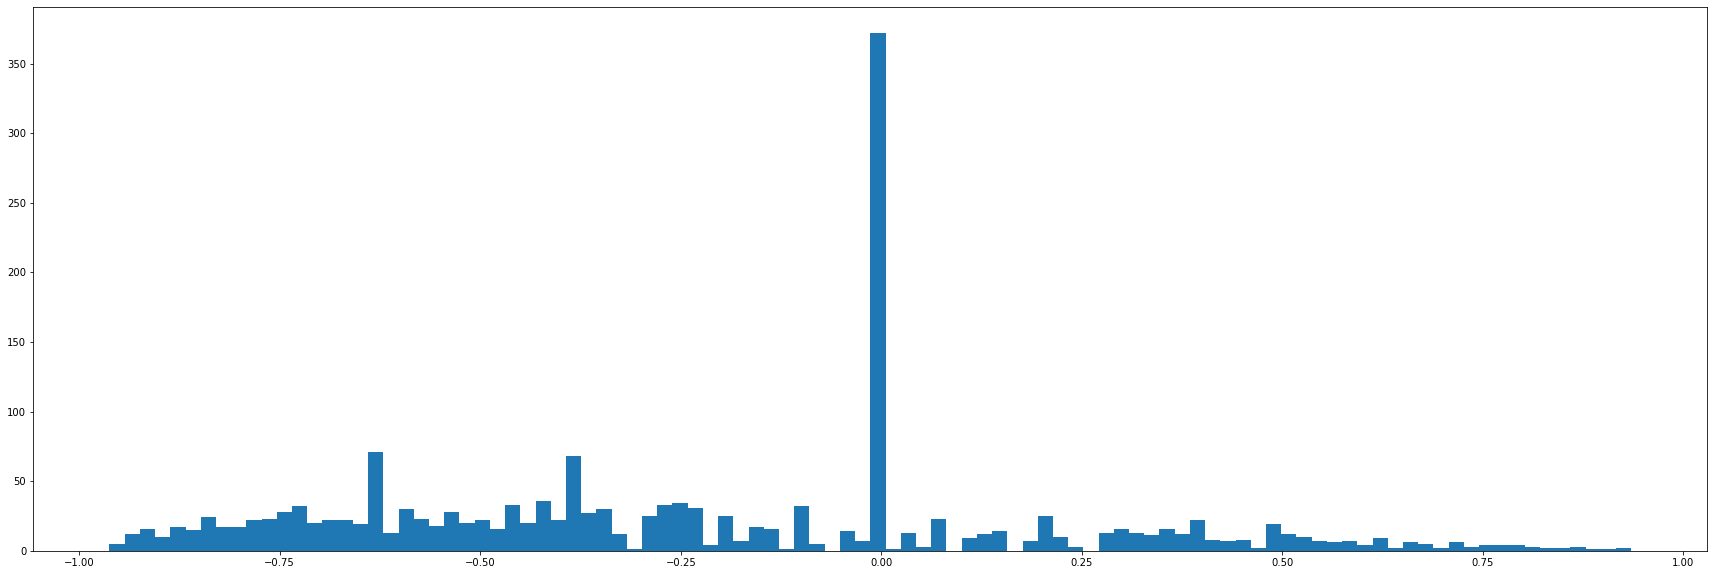

In [281]:
plt.figure(figsize=(30, 10))
plt.hist(sent_df.sentiment_score, bins=100);

In [282]:
sent_df.corr()

,num_comments,score,sentiment_score
num_comments,1.000000,0.365852,-0.045247
score,0.365852,1.000000,-0.031750
sentiment_score,-0.045247,-0.031750,1.000000


**Sentiment of the title has very little predictive power**

In [283]:
tone_df = sent_df[~sent_df.tone_analyzer.isnull()]

In [286]:
def extract_score_from_tones(tones, tone_id):
    """
    Extracts specific tone score from array of tone values

    Args:
        tones (list): List of tone objects from IBM tone API
        tone_id (str): specific tone id

    Returns:
        Score as float if it exists. NaN if not.
    """
    matching_tones = [t for t in tones if t['tone_id'] == tone_id]

    if not matching_tones:
        return np.nan

    return matching_tones[0]['score']

def extract_score(raw_tone, tone_id):
    """
    Extracts specific tone score from raw tone API response

    Args:
        raw_tone (obj): Raw response object from IBM tone API
        tone_id (str): specific tone id

    Returns:
        Score as float if it exists. NaN if not.
    """
    if not raw_tone.get('document_tone'):
        return np.nan

    tones = raw_tone.get('document_tone').get('tones')
    return extract_score_from_tones(tones, tone_id)

In [287]:
extract_score(tone_df.tone_analyzer[0], 'sadness')

0.5383

In [288]:
for t in ['analytical', 'anger', 'confident', 'fear', 'joy', 'sadness', 'tentative']:
    tone_df[t] = tone_df.tone_analyzer.map(lambda ta: extract_score(ta, t))

In [289]:
tone_df.corr()

,num_comments,score,sentiment_score,analytical,anger,confident,fear,joy,sadness,tentative
num_comments,1.000000,0.365852,-0.045247,-0.009717,0.010183,-0.137431,-0.078975,0.125040,0.068902,-0.156760
score,0.365852,1.000000,-0.031750,0.047610,-0.124516,-0.006808,-0.060645,-0.136021,0.110920,0.059865
sentiment_score,-0.045247,-0.031750,1.000000,0.004262,-0.152226,0.014938,-0.176815,0.204716,-0.192500,0.080110
analytical,-0.009717,0.047610,0.004262,1.000000,-0.312411,0.050405,0.170658,-0.077937,-0.060098,0.114762
anger,0.010183,-0.124516,-0.152226,-0.312411,1.000000,-0.998636,1.000000,NaN,NaN,-0.856423
confident,-0.137431,-0.006808,0.014938,0.050405,-0.998636,1.000000,0.332074,-0.153151,0.145328,NaN
fear,-0.078975,-0.060645,-0.176815,0.170658,1.000000,0.332074,1.000000,NaN,0.731528,-0.072021
joy,0.125040,-0.136021,0.204716,-0.077937,NaN,-0.153151,NaN,1.000000,NaN,0.246691
sadness,0.068902,0.110920,-0.192500,-0.060098,NaN,0.145328,0.731528,NaN,1.000000,-0.070160
tentative,-0.156760,0.059865,0.080110,0.114762,-0.856423,NaN,-0.072021,0.246691,-0.070160,1.000000


In [290]:
tone_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1806 entries, 2181 to 368
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   _id              1806 non-null   object 
 1   num_comments     1806 non-null   int64  
 2   score            1806 non-null   int64  
 3   url              1806 non-null   object 
 4   sentiment_score  1806 non-null   float64
 5   tone_analyzer    1806 non-null   object 
 6   analytical       650 non-null    float64
 7   anger            52 non-null     float64
 8   confident        136 non-null    float64
 9   fear             246 non-null    float64
 10  joy              114 non-null    float64
 11  sadness          204 non-null    float64
 12  tentative        210 non-null    float64
dtypes: float64(8), int64(2), object(3)
memory usage: 277.5+ KB


**Get some corr from the tones but relatively few of the articles have it**

anger/tentative, confident/joy/sadness

Prob anger and joy

# Length of Article

In [308]:
length_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {'text_razor': {'$exists': True}},
        {'score': 1, 'num_comments': 1, 'url': 1, 'text_razor': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [309]:
# remove errors
length_df = length_df[length_df.text_razor.map(lambda tr: type(tr) != str)]

In [313]:
length_df['article_length'] = length_df.text_razor.map(lambda tr: len(tr.get('response', {}).get('cleanedText', '')), na_action='ignore')

In [327]:
length_df[length_df.article_length > 10000].corr()

,num_comments,score,article_length
num_comments,1.000000,0.046697,0.269217
score,0.046697,1.000000,-0.059554
article_length,0.269217,-0.059554,1.000000


In [325]:
length_df[length_df.article_length < 5000].corr()

,num_comments,score,article_length
num_comments,1.000000,0.011697,0.091233
score,0.011697,1.000000,0.018789
article_length,0.091233,0.018789,1.000000


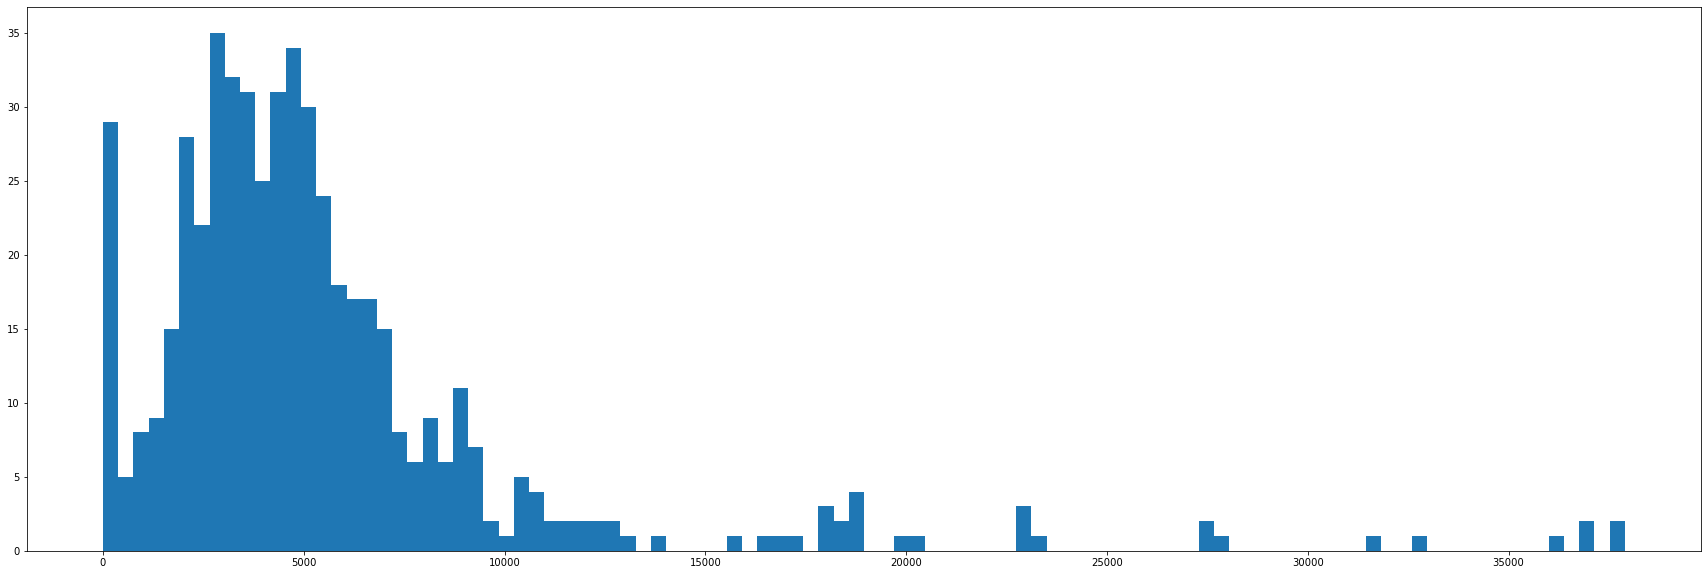

In [316]:
plt.figure(figsize=(30, 10))
plt.hist(length_df[length_df.article_length < 40000].article_length, bins=100);

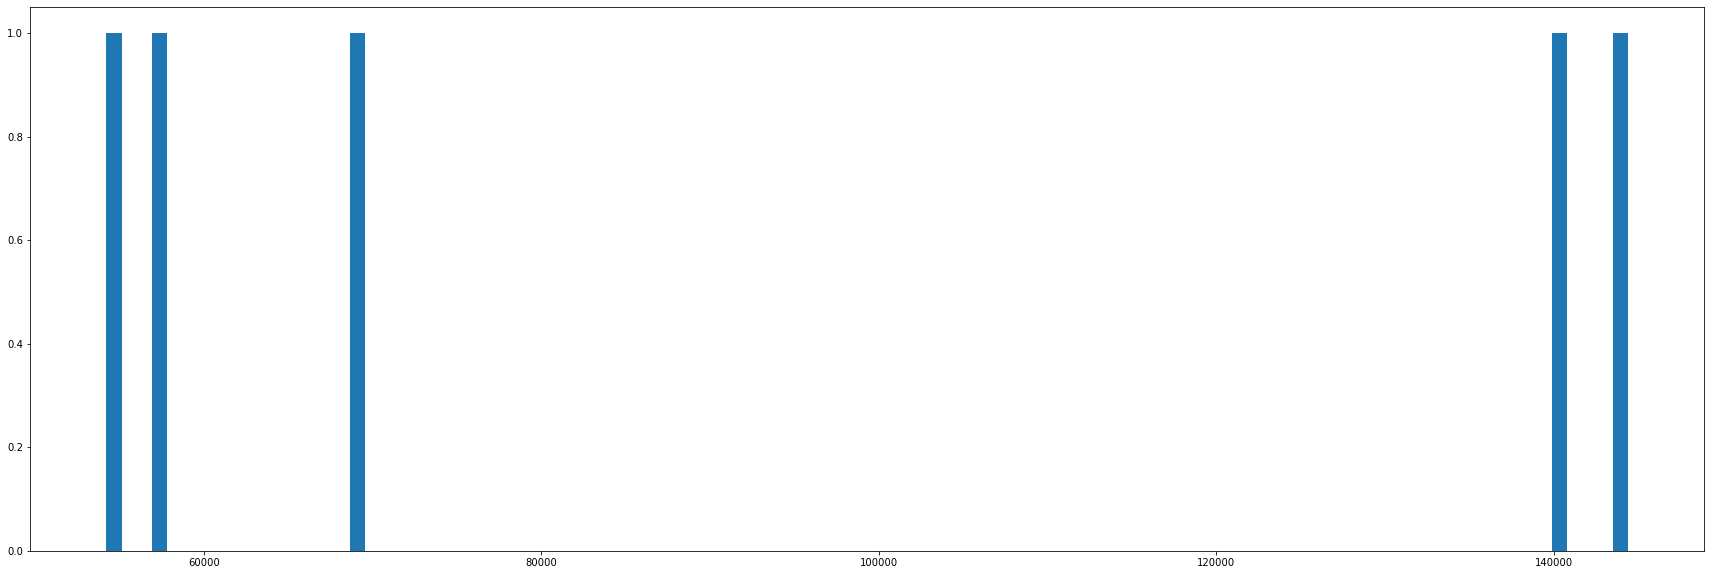

In [320]:
plt.figure(figsize=(30, 10))
plt.hist(length_df[length_df.article_length > 40000].article_length, bins=100);

**Length has some correlation**

Might have some outliers as well

Seems like there's lots of changes in correlation depending on cutoff.

Maybe use a CART model or bucket the article length

# Article Source

In [328]:
source_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [356]:
source_df.url.map(lambda u: get_tld(u, as_object=True).domain).value_counts()

theguardian       243
reuters           114
bbc                98
independent        98
cnn                84
                 ... 
digitaljournal      1
modarso             1
nasa                1
thetyee             1
lbcnews             1
Name: url, Length: 328, dtype: int64

# Time of Day

In [ ]:
# topics (hundreds)
# article source (328 different ones)
# time of day ()
# subreddit activity (num comments in last however long)

In [370]:
date_df = pd.DataFrame.from_records(
    db.submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1, 'created_utc': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [371]:
date_df['posted_date'] = date_df.created_utc.map(datetime.fromtimestamp)

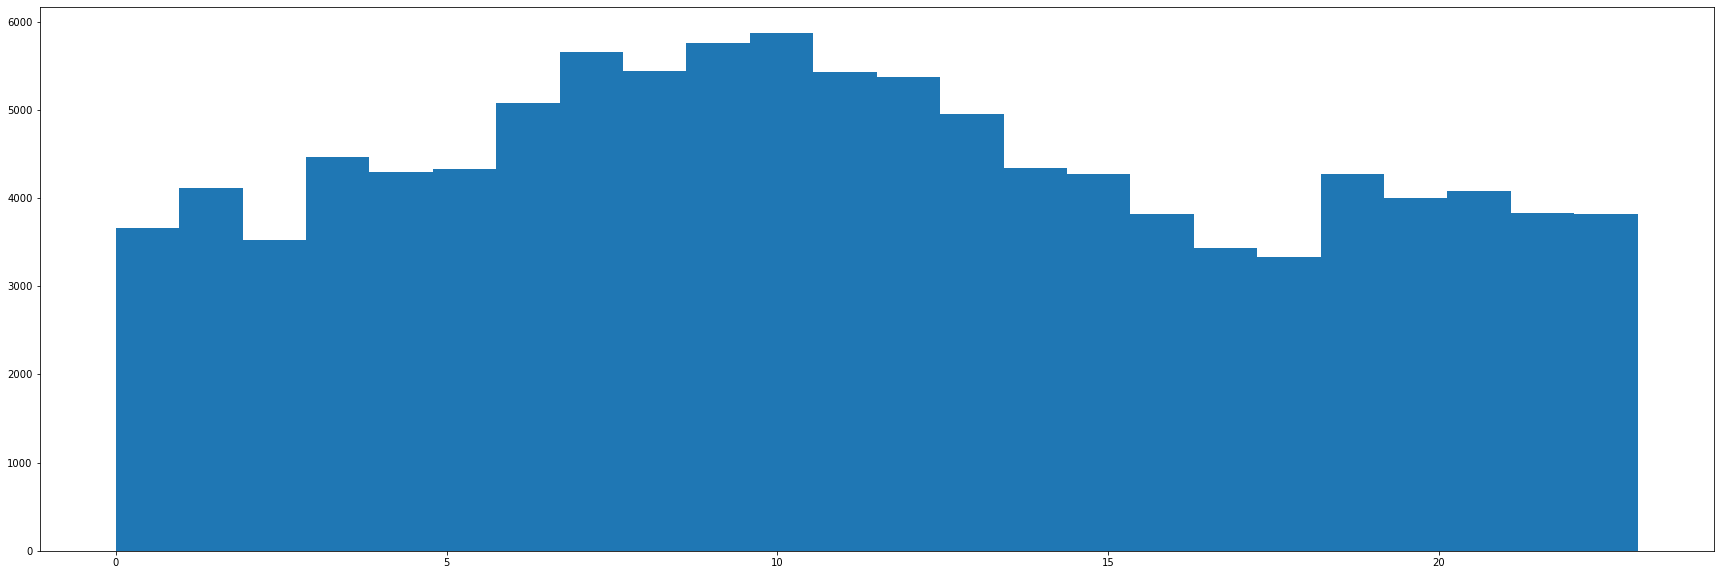

In [372]:
plt.figure(figsize=(30, 10))
plt.hist(date_df.posted_date.map(lambda d: d.hour), bins=24);

In [373]:
date_df['posted_hour'] = date_df.posted_date.map(lambda d: d.hour)

In [398]:
date_df['hour_bucket'] = date_df.posted_hour.map(lambda h: h // 4)

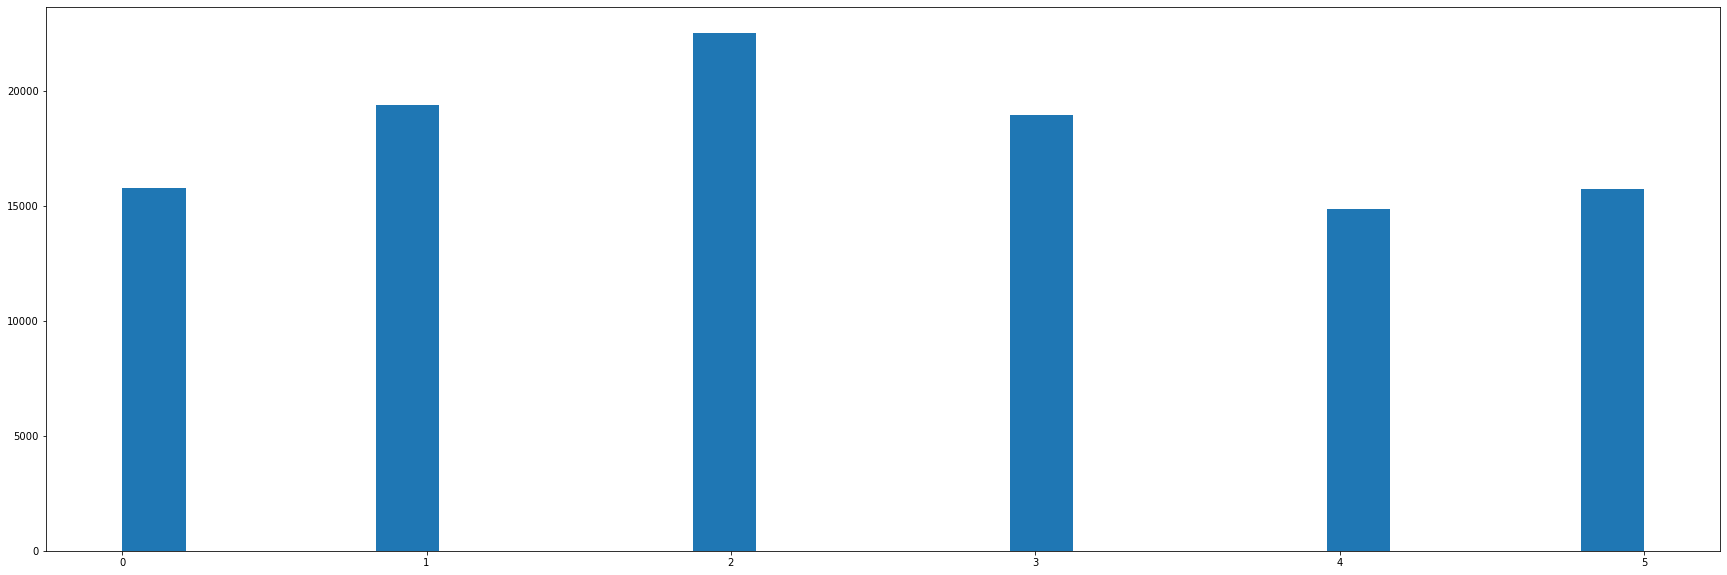

In [399]:
plt.figure(figsize=(30, 10))
plt.hist(date_df.hour_bucket, bins=24);

In [400]:
date_df.groupby('hour_bucket').agg('mean')

,created_utc,num_comments,score,posted_hour
hour_bucket,,,,
0,1.578716e+09,24.423650,19.275265,1.557445
1,1.578684e+09,50.927505,35.231282,5.625123
2,1.578484e+09,45.850793,34.593671,9.502289
3,1.578569e+09,42.635735,24.408604,13.396727
4,1.578662e+09,52.390195,29.073742,17.542393
5,1.578930e+09,33.210315,18.653396,21.474561


In [401]:
date_df[date_df.num_comments > 1].groupby('hour_bucket').agg('mean')

,created_utc,num_comments,score,posted_hour
hour_bucket,,,,
0,1.578302e+09,56.849881,43.659780,1.552319
1,1.578298e+09,105.064813,71.745775,5.621604
2,1.578465e+09,90.310436,67.231904,9.494378
3,1.578556e+09,80.194823,45.039323,13.428771
4,1.578644e+09,96.806311,52.833624,17.513096
5,1.578605e+09,71.013242,38.787850,21.434539


**Group time of day into 6 buckets**

# Comments Before Post

In [406]:
comm_bef_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1, 'created_utc': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [407]:
def get_preceeding_comment_count(timestamp, minutes):
    return db.comments.count_documents({'created_utc': {'$gt': timestamp - 60 * minutes, '$lt': timestamp}})

In [409]:
for m in [60, 30, 20, 10, 5, 1]:
    comm_bef_df['num_comm_' + str(m)] = comm_bef_df.created_utc.map(lambda t: get_preceeding_comment_count(t, m))

In [411]:
comm_bef_df.corr()

,created_utc,num_comments,score,num_comm_60,num_comm_30,num_comm_20,num_comm_10,num_comm_5,num_comm_1
created_utc,1.000000,-0.014328,-0.070511,0.207176,0.203238,0.202800,0.201219,0.198701,0.189193
num_comments,-0.014328,1.000000,0.365852,0.000392,0.003837,0.004265,0.009004,0.004368,0.008092
score,-0.070511,0.365852,1.000000,-0.004358,-0.004862,-0.004546,-0.001441,-0.004659,0.000590
num_comm_60,0.207176,0.000392,-0.004358,1.000000,0.989064,0.980075,0.967857,0.955447,0.900799
num_comm_30,0.203238,0.003837,-0.004862,0.989064,1.000000,0.996757,0.988277,0.977258,0.920812
num_comm_20,0.202800,0.004265,-0.004546,0.980075,0.996757,1.000000,0.993802,0.983643,0.927565
num_comm_10,0.201219,0.009004,-0.001441,0.967857,0.988277,0.993802,1.000000,0.991243,0.934415
num_comm_5,0.198701,0.004368,-0.004659,0.955447,0.977258,0.983643,0.991243,1.000000,0.942543
num_comm_1,0.189193,0.008092,0.000590,0.900799,0.920812,0.927565,0.934415,0.942543,1.000000


# Submissions Before

In [424]:
sub_bef_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1, 'created_utc': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [425]:
def get_preceeding_submission_count(timestamp, minutes):
    return db.submissions.count_documents({'created_utc': {'$gt': timestamp - 60 * minutes, '$lt': timestamp}})

In [426]:
for m in [60, 30, 20, 10, 5, 1]:
    sub_bef_df['num_sub_' + str(m)] = sub_bef_df.created_utc.map(lambda t: get_preceeding_submission_count(t, m))
    

In [427]:
sub_bef_df.corr()

,created_utc,num_comments,score,num_sub_60,num_sub_30,num_sub_20,num_sub_10,num_sub_5,num_sub_1
created_utc,1.000000,-0.014328,-0.070511,0.409650,0.341015,0.302331,0.247509,0.192851,0.105872
num_comments,-0.014328,1.000000,0.365852,-0.028530,-0.034029,-0.043056,-0.033191,-0.053935,-0.031013
score,-0.070511,0.365852,1.000000,-0.005848,0.009003,0.007333,0.011702,-0.010892,0.013293
num_sub_60,0.409650,-0.028530,-0.005848,1.000000,0.882430,0.805228,0.662691,0.517438,0.286902
num_sub_30,0.341015,-0.034029,0.009003,0.882430,1.000000,0.923909,0.762914,0.586888,0.327437
num_sub_20,0.302331,-0.043056,0.007333,0.805228,0.923909,1.000000,0.837374,0.662420,0.362404
num_sub_10,0.247509,-0.033191,0.011702,0.662691,0.762914,0.837374,1.000000,0.798182,0.418969
num_sub_5,0.192851,-0.053935,-0.010892,0.517438,0.586888,0.662420,0.798182,1.000000,0.526877
num_sub_1,0.105872,-0.031013,0.013293,0.286902,0.327437,0.362404,0.418969,0.526877,1.000000


**TODO - seems really weird that it's so correlated with created_utc**

# Media Cloud

In [40]:
with open('../data/raw/media_cloud_all_sources.pickle', 'rb') as read_file:
    mc_df = pickle.load(read_file)

In [49]:
posts_df = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {},
        {'score': 1, 'num_comments': 1, 'url': 1, 'created_utc': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')
posts_df['tld'] = posts_df.url.map(lambda u: get_tld(u, as_object=True).domain)
mereged_df = posts_df.merge(mc_df, how='left', on='tld')

In [50]:
tags = []
_ = mereged_df[~mereged_df.media_source_tags.isnull()].media_source_tags.map(lambda a: tags.append(a))

In [51]:
tags_df = pd.DataFrame.from_records([t for t_list in tags for t in t_list])

In [52]:
t_df = mereged_df[~mereged_df.media_source_tags.isnull()].copy()
for t in tags_df.tag.value_counts()[:99].index[61:81]:
    t_df[t] = t_df.media_source_tags.map(lambda tags: 1 if t in [x['tag'] for x in tags] else 0)

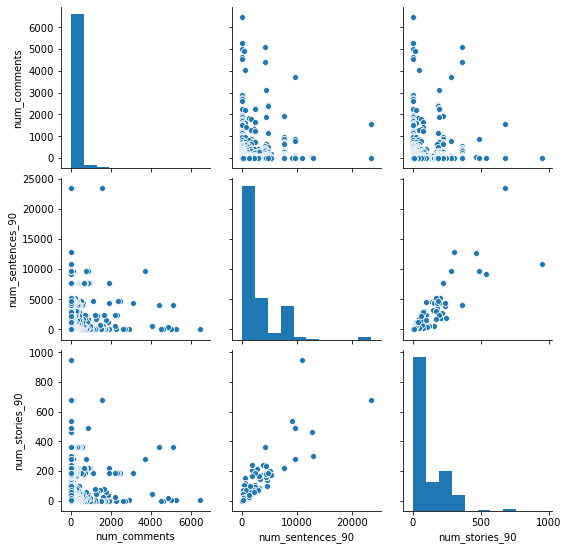

In [489]:
sns.pairplot(t_df[['num_comments', 'num_sentences_90', 'num_stories_90']])

In [ ]:
# unpopular: Ford_Special_Report, U_S_Partisan_Sources_2012___Liberal, pub_GBR, national, european_union, GB, Yahoo_U_S_Political_Blogs_2008_, srhr_20140527
# popular: 

In [53]:
exploded_df = t_df.explode(column='media_source_tags')
exploded_df['tag'] = exploded_df.media_source_tags.map(lambda t: t['tag'])

In [54]:
by_tag_df = exploded_df.groupby('tag').agg({'num_comments': ['count', 'mean', 'median']})
by_tag_df.columns = [x[1] for x in by_tag_df.columns]
by_tag_df[by_tag_df['count'] > 15]['mean'].sort_values(ascending=False)

tag
oped_project                                    330.000000
hrcheck                                         239.200000
PK                                              235.782609
pmcheck                                         225.333333
geo_USA                                         198.379562
newspapers                                      183.307692
gates_us_20160203                               175.648352
gates_20160203                                  170.382979
Global_English_Language_Sources_                162.487903
left                                            159.600000
United States                                   156.307978
print_native                                    143.520833
pub_USA                                         142.071594
Commonwealth of Australia                       137.093750
center                                          134.674157
technorati_uspolitics_20100709                  131.112000
U_S__Top_Online_News_2017                       127.

In [55]:
by_tag_df[by_tag_df['count'] > 15]['median'].sort_values(ascending=False)

tag
U_S__Partisan_Sources_2012___Conservative       12.5
digital_native                                  12.0
spinn3r_us_20100407                             12.0
PK                                              11.0
oped_project                                    11.0
U_S__Top_Digital_Native_News_2015               10.5
oceania                                         10.0
left                                            10.0
right                                           10.0
no_rss                                          10.0
buzzfeed_hyperpartisan_2017                      9.5
buzzfeed_hyperpartisan_2017_left                 9.0
U_S__Top_Digital_Native_News_2016                9.0
i_and_d_polyblogs                                9.0
USA_GA                                           8.5
U_S__Campaigns_and_Elections_2008                8.0
France___National                                8.0
pmcheck                                          8.0
Commonwealth of Australia                 

In [56]:
# percentage of unique articles in with over X comments for each tag
# assume each article only got one of every tag
exploded_df['over_100'] = exploded_df.num_comments.map(lambda x: 1 if x > 500 else 0)
expl_bucket_df = exploded_df.groupby('tag').agg({'over_100': ['sum', 'count']})
expl_bucket_df.columns = ['over_100_' + x[1] for x in expl_bucket_df.columns]

In [57]:
expl_bucket_df['perc_over_100'] = expl_bucket_df.over_100_sum / expl_bucket_df.over_100_count
expl_bucket_df[expl_bucket_df.over_100_count > 15].sort_values('over_100_count', ascending=False)

,over_100_sum,over_100_count,perc_over_100
tag,,,
en,78,1892,0.041226
center_left,29,811,0.035758
none,27,752,0.035904
Leo_s_Collection,25,601,0.041597
spidered,26,576,0.045139
United_States___National,24,574,0.041812
U.S. Mainstream Media,19,557,0.034111
United States,34,539,0.063080
europe_media_monitor_20121015,12,503,0.023857


In [58]:
posts_df.shape

(1806, 6)

In [59]:
exploded_df.tag.value_counts()[:100]

en                                              1892
center_left                                      811
none                                             752
Leo_s_Collection                                 601
spidered                                         576
United_States___National                         574
U.S. Mainstream Media                            557
United States                                    539
europe_media_monitor_20121015                    503
webnews                                          496
general_news                                     492
pub_USA                                          433
US_Top_w_o_Bleacher                              428
U_S__Top_Online_News_2015                        428
cindy_test_from_collection2                      385
technorati_uspolitics_20100709                   375
national                                         371
pub_GBR                                          303
cindy_csv_3                                   

## Perhaps a simple decision tree could help

In [60]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
dummied_media = pd.get_dummies(exploded_df[['_id', 'num_comments', 'tag']], columns=['tag'])
media_df = dummied_mediaa.groupby('_id').agg('sum')
media_df['num_comments'] = dummied_media.groupby('_id').num_comments.agg('mean')

In [73]:
X_media, y_media = media_df.drop(columns=['num_comments']), media_df.num_comments

In [74]:
rf = RandomForestRegressor(max_depth=3, min_samples_leaf=10, n_estimators=100)
rf.fit(X_media, y_media)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [75]:
for n, i in sorted(zip(X_media.columns, rf.feature_importances_), key=lambda x: -x[1])[:100]:
    print(n, '-', i, ' - ', exploded_df.tag.value_counts()[n.replace('tag_', '')])

tag_technorati_uspolitics_20100709 - 0.25837020708842456  -  375
tag_United States - 0.09114578263030458  -  539
tag_PK - 0.057970316464229385  -  23
tag_spidered - 0.041297990400936416  -  576
tag_geo_USA - 0.040681559997091964  -  137
tag_national - 0.03728563292520265  -  371
tag_pub_USA - 0.03402111451170593  -  433
tag_none - 0.031166324783632095  -  752
tag_left - 0.02576090926595744  -  105
tag_Geo_diversity_Study_US_Sources - 0.025450134600162638  -  184
tag_oped_project - 0.02521627604021017  -  16
tag_technorati_uspolitics_20100709_coded - 0.023805076677795287  -  33
tag_XX - 0.023671603475402855  -  117
tag_hrcheck - 0.022523275697115097  -  20
tag_europe_media_monitor_20121015 - 0.02168537278794462  -  503
tag_Global_English_Language_Sources_ - 0.020596817566751854  -  248
tag_center_left - 0.018448756384120385  -  811
tag_United_States___National - 0.016574344536288647  -  574
tag_gv_blogs_20130329 - 0.014983403675916551  -  180
tag_U_S__Wire_Services - 0.01413502929823437

In [77]:
X_media.to_csv('../data/processed/media_tags.csv')

**Start with these seven**

tag_technorati_uspolitics_20100709 - 0.20196404775696292  -  375

tag_none - 0.12137261022139009  -  752

tag_print_native - 0.07275778965467629  -  144

tag_national - 0.06898739593169503  -  371

tag_geo_USA - 0.06064960463497495  -  137

tag_en - 0.04420968344305795  -  1892

tag_United States - 0.03967121373143046  -  539

# Coarse Topics

In [ ]:
# dummy out every entity and topic
# use random forest to determine most influential

In [7]:
topics_raw = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {'text_razor': {'$exists': True}},
        {'score': 1, 'num_comments': 1, 'url': 1, 'created_utc': 1, 'text_razor': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [18]:
topics_df = topics_raw.copy()
topics_df = topics_df[topics_df.text_razor.map(lambda x: bool(type(x) != str and x.get('response')))]
topics_df['topics'] = topics_df.text_razor.map(lambda x: x.get('response').get('coarseTopics'), na_action='ignore')
topics_df = topics_df.explode('topics')
topics_df['topic_label'] = topics_df.topics.map(lambda x: x['label'], na_action='ignore')
topics_df['topic_score'] = topics_df.topics.map(lambda x: x['score'], na_action='ignore')
topics_df = topics_df.dropna().pivot(index='_id', columns='topic_label', values='topic_score')


In [30]:
topics_cleaned_df = topics_df.fillna(-99)
topics_cleaned_df = topics_cleaned_df.merge(topics_raw[['_id', 'num_comments']], how='left', on='_id')

In [79]:
rf = RandomForestRegressor()
X_topics, y_topics = topics_cleaned_df.drop(columns=['_id', 'num_comments']), topics_cleaned_df.num_comments
rf.fit(X_topics, y_topics)

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [80]:
for n, i in sorted(zip(X_topics.columns, rf.feature_importances_), key=lambda x: -x[1])[:100]:
    print(n, '-', i)

Culture - 0.21267589093722963
Technology - 0.158025315310884
Belief - 0.1304144473740582
Violence - 0.10848340009364994
Politics - 0.08674598458887436
Science - 0.06344720936641546
Nature - 0.062059176862327016
Law - 0.054552002083970076
Business - 0.04775965774460023
Arts - 0.03731299992051038
Health - 0.032224998505488524
Education - 0.005514048590831355
Weather - 0.0005196317374154085
Leisure - 0.00026523688374539974
Sports - 0.0


**Perhaps start with these**

Technology - 0.1728671848685763

Culture - 0.1643839775008902

Science - 0.13792540497011024

Belief - 0.11504683348951907

Law - 0.09850467236463835

Violence - 0.06909310285983558

Business - 0.06406413762316397

Nature - 0.05487676834119273

Arts - 0.04581947901101145

Politics - 0.042411313080290884

In [78]:
topics_cleaned_df.to_csv('../data/processed/topics.csv')

# Entities

In [91]:
entities_raw = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {'text_razor': {'$exists': True}},
        {'score': 1, 'num_comments': 1, 'url': 1, 'created_utc': 1, 'text_razor': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

## Entity Counts

In [99]:
entities_df = entities_raw.copy()
entities_df = entities_df[entities_df.text_razor.map(lambda x: bool(type(x) != str and x.get('response')))]
entities_df['entities'] = entities_df.text_razor.map(lambda x: x.get('response').get('entities'), na_action='ignore')
entities_df = entities_df.explode('entities')
entities_df['entity_label'] = entities_df.entities.map(lambda x: x['entityId'], na_action='ignore')
entities_df['entity_score'] = entities_df.entities.map(lambda x: x['relevanceScore'], na_action='ignore')
entities_df = entities_df.groupby(['_id', 'entity_label']).num_comments.agg('count').reset_index()
entities_df = entities_df.dropna().pivot(index='_id', columns='entity_label', values='num_comments')
entities_df = entities_df.fillna(0)
entities_df = entities_df.merge(entities_raw[['_id', 'num_comments']], how='left', on='_id')

In [141]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5)
X_entity, y_entity = entities_df.drop(columns=['_id', 'num_comments']), entities_df.num_comments
rf.fit(X_entity, y_entity)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [144]:
res = []
for n, i in sorted(zip(X_entity.columns, rf.feature_importances_), key=lambda x: -x[1])[:100]:
    res.append((n, i, np.sum(entities_df.replace(0, np.nan).groupby('_id').agg('count')).loc[n]))

In [145]:
[[x[0] for x in res if x[2] > 10]]

[['Photograph',
  'Misinformation',
  'United States Secretary of the Treasury',
  'Somerset',
  'Greta',
  'Davos',
  'Sustainable development',
  'Advertising',
  'Sweden',
  'United States Department of the Treasury',
  '1.5',
  'Interview',
  '2020-03-16T00:00:00.000+00:00',
  '10',
  'Climate crisis',
  'Experience',
  'YouTube',
  'Flight',
  'Climate change',
  'Bloomberg L.P.',
  '2020-03-01T00:00:00.000+00:00',
  'Debate',
  'Water scarcity',
  'Privacy',
  'Tourism',
  'Property']]

In [146]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5)
X_entity, y_entity = entities_df.drop(columns=['_id', 'num_comments']), entities_df.num_comments
rf.fit(X_entity[[x[0] for x in res if x[2] > 10]], y_entity)

for n, i in sorted(zip(X_entity[[x[0] for x in res if x[2] > 10]].columns, rf.feature_importances_), key=lambda x: -x[1])[:100]:
    print(n, i, np.sum(entities_df.replace(0, np.nan).groupby('_id').agg('count')).loc[n])

Misinformation 0.12037553901094346 14
Sweden 0.08486609848775309 96
Photograph 0.0791816725314728 36
10 0.07763132510560528 122
Property 0.07446386851766364 24
Tourism 0.07298453465453249 12
Sustainable development 0.06900748357207541 13
Interview 0.04922628319832982 16
United States Secretary of the Treasury 0.04907956007286725 12
Somerset 0.04897002558525911 13
Climate change 0.03843582009859402 407
1.5 0.029180795828344014 22
YouTube 0.027172094152058193 19
Privacy 0.019983838661779454 37
Greta 0.018062685213472873 14
2020-03-01T00:00:00.000+00:00 0.017976660801825785 41
2020-03-16T00:00:00.000+00:00 0.017715507166818918 61
United States Department of the Treasury 0.0169831828279169 11
Climate crisis 0.016492285846943445 95
Flight 0.016195827897773234 13
Davos 0.013655341839591242 58
Debate 0.013563773827026891 50
Advertising 0.012545495189583734 86
Experience 0.01086905190560867 22
Bloomberg L.P. 0.004613487045700391 17
Water scarcity 0.0007677609604600231 15


## By Relevance Scores

In [153]:
entities_rel_df = entities_raw.copy()
entities_rel_df = entities_rel_df[entities_rel_df.text_razor.map(lambda x: bool(type(x) != str and x.get('response')))]
entities_rel_df['entities'] = entities_rel_df.text_razor.map(lambda x: x.get('response').get('entities'), na_action='ignore')
entities_rel_df = entities_rel_df.explode('entities')
entities_rel_df['entity_label'] = entities_rel_df.entities.map(lambda x: x['entityId'], na_action='ignore')
entities_rel_df['entity_score'] = entities_rel_df.entities.map(lambda x: x['relevanceScore'], na_action='ignore')
entities_rel_df = entities_rel_df.groupby(['_id', 'entity_label']).entity_score.agg('max').reset_index()
entities_rel_df = entities_rel_df.dropna().pivot(index='_id', columns='entity_label', values='entity_score')
entities_rel_df = entities_rel_df.fillna(0)
entities_rel_df = entities_rel_df.merge(entities_raw[['_id', 'num_comments']], how='left', on='_id')

In [168]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5)
X_entity, y_entity = entities_df.drop(columns=['_id', 'num_comments']), entities_df.num_comments
rf.fit(X_entity, y_entity)
res_rel = []
for n, i in sorted(zip(X_entity.columns, rf.feature_importances_), key=lambda x: -x[1])[:100]:
    res_rel.append((n, i, np.sum(entities_df.replace(0, np.nan).groupby('_id').agg('count')).loc[n]))

In [169]:
res_rel

[('Photograph', 0.040505995571389744, 36),
 ('University of Bristol', 0.03922501436398359, 9),
 ('Juan Medina', 0.036018651762584175, 1),
 ('Misinformation', 0.03516014151868126, 14),
 ('Right Livelihood Award', 0.03187737641012653, 3),
 ('United States Secretary of the Treasury', 0.030868819373311228, 12),
 ('www.trust.org', 0.0258616944661361, 1),
 ('Racial equality', 0.025818493844430183, 3),
 ('Hate speech', 0.024172382319404405, 2),
 ('Social sustainability', 0.02371781615366901, 1),
 ('Brown University', 0.022848952838717285, 5),
 ('Basecamp (company)', 0.019171168251498612, 2),
 ('Avon and Somerset Constabulary', 0.017977093409427977, 4),
 ('Greta', 0.01694688331858577, 14),
 ('Avaaz', 0.015986749169834426, 3),
 ('Max Herman', 0.01485340128537494, 2),
 ('Milne', 0.014045463201570029, 1),
 ('Ole von Uexkuell', 0.013934952252526167, 1),
 ('Swedish krona', 0.013057091216075335, 1),
 ('Human trafficking', 0.012644939502255106, 5),
 ('12:03', 0.012480581089242215, 1),
 ('Patient', 0.

In [170]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=5)
X_entity, y_entity = entities_df.drop(columns=['_id', 'num_comments']), entities_df.num_comments
rf.fit(X_entity[[x[0] for x in res_rel if x[2] > 10]], y_entity)

for n, i in sorted(zip(X_entity[[x[0] for x in res_rel if x[2] > 10]].columns, rf.feature_importances_), key=lambda x: -x[1])[:100]:
    print(n, i, np.sum(entities_df.replace(0, np.nan).groupby('_id').agg('count')).loc[n])

Misinformation 0.1512806670780991 14
Interview 0.10399724100814021 16
2020-03-16T00:00:00.000+00:00 0.10258526446775515 61
Photograph 0.1022907261827275 36
Somerset 0.09006567479125846 13
United States Secretary of the Treasury 0.057993331387453294 12
Twitter 0.04787051479966641 81
Privacy 0.040140488689994695 37
Economy 0.039292740240264155 104
Advertising 0.036870333584311854 86
Climate crisis 0.03129865873957653 95
Davos 0.02986497112584462 58
Greta 0.02974453430678634 14
England 0.028242587195738956 16
Debate 0.025217275990835654 50
YouTube 0.024846573184338205 19
Scientific consensus on climate change 0.02338719157632057 18
United States Department of the Treasury 0.01655373413342158 11
Video 0.012327401592474677 15
Bloomberg L.P. 0.003592742071125611 17
Discourse 0.0025373478538663345 11


# Article Length

In [171]:
length_raw = pd.DataFrame.from_records(
    db.climate_submissions.find(
        {'text_razor': {'$exists': True}},
        {'score': 1, 'num_comments': 1, 'url': 1, 'created_utc': 1, 'text_razor': 1}
    )
).sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'], keep='first')

In [176]:
length_df = length_raw.copy()
length_df = length_df[length_df.text_razor.map(lambda x: bool(type(x) != str and x.get('response')))]
length_df['length'] = length_df.text_razor.map(lambda x: len(x['response']['cleanedText']))

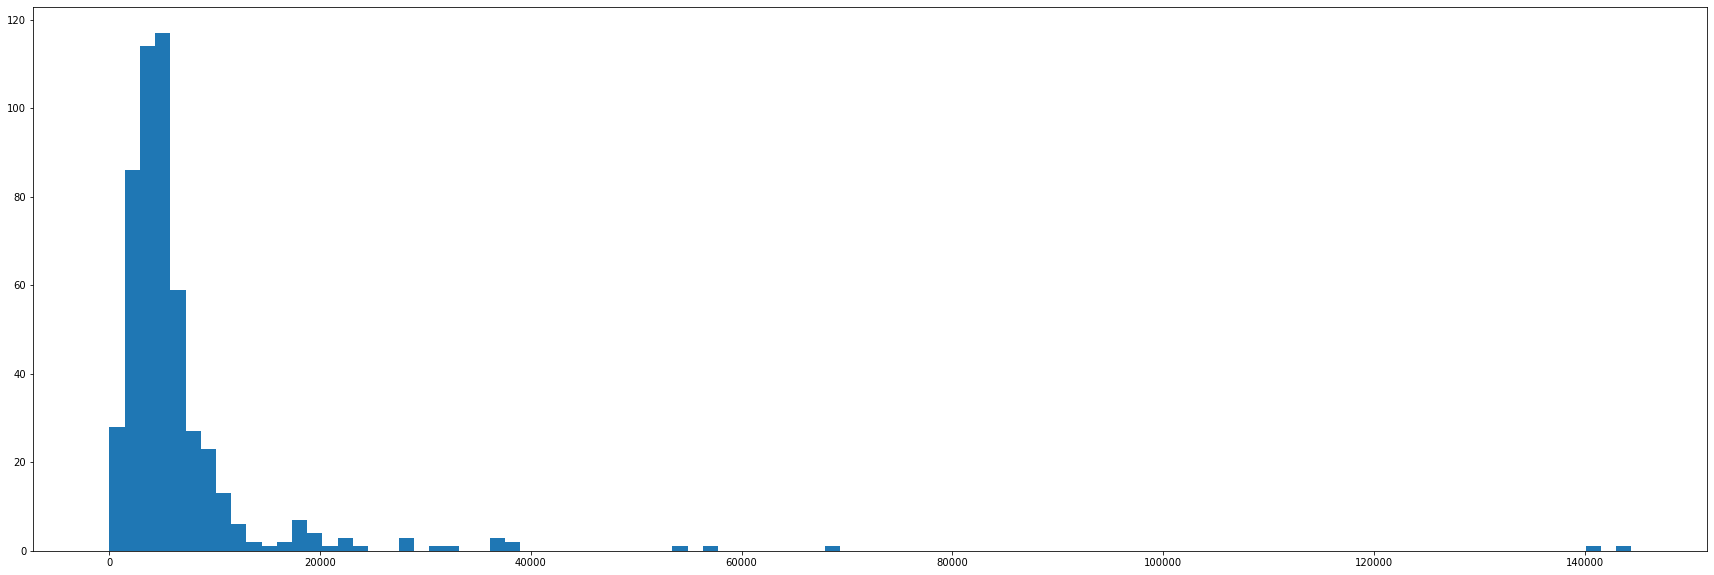

In [178]:
plt.figure(figsize=(30, 10))
plt.hist(length_df.length, bins=100);

In [179]:
# Major outliers

In [206]:
length_df[(length_df.length < 40000) & (length_df.length > 20000)].text_razor.iloc[4]['response']['cleanedText']

'Follow CNN\nAustralia\'s climate crisis has been building for years but no one listened\nUpdated 0941 GMT (1741 HKT) February 13, 2020\nChat with us in Facebook Messenger. Find out what\'s happening in the world as it unfolds.\nJUST WATCHED\n(CNN)\nAustralia was already grappling with extreme heat and one of the worst droughts on record when devastating bushfires tore through the bone dry land.\nFor months, the infernos have raged through Australia\'s southeast, leaving parts of the country choking under some of the worst air pollution in the world.\nSince September, more than 18 million hectares (44 million acres) of bush, land and forest have been burned. At least 28 people have died , around 3,000 homes have been destroyed and about one billion animals could have been affected.\nHeavy rain down the east coast this week has temporarily eased the crisis , but authorities warn the fire risk is not over --  bushfire season typically ends in March. Only last week, Australia\'s capital c

In [205]:
length_df[(length_df.length < 40000) & (length_df.length > 20000)].iloc[4].url

'https://edition.cnn.com/2020/02/12/australia/australia-extreme-climate-bushfire-intl-hnk/index.html'

In [212]:
length_df[(length_df.length > 15000)].sort_values('length')

,_id,created_utc,num_comments,score,url,text_razor,length
610,5e65d005bd71f87e9891caf3,1579680775,3,1,http://www.vice.com/en_us/article/mbmkz8/us-mi...,{'response': {'cleanedText': 'More Advertiseme...,15800
161,5e65d004bd71f87e9891c932,1582410777,33,1,https://www.independent.co.uk/news/world/ameri...,{'response': {'cleanedText': 'network account ...,16426
603,5e65d005bd71f87e9891caec,1579713969,546,1,https://www.independent.co.uk/environment/davi...,{'response': {'cleanedText': 'network account ...,16864
290,5e65d004bd71f87e9891c9b3,1581931505,0,1,https://www.crs.org/stories/power-climate-chan...,{'response': {'cleanedText': 'Share On Climate...,17412
604,5e65d005bd71f87e9891caed,1579706557,52,1,https://www.independent.co.uk/environment/gret...,{'response': {'cleanedText': 'network account ...,17985
254,5e65d004bd71f87e9891c98f,1582031079,1031,1,https://www.independent.co.uk/environment/clim...,{'response': {'cleanedText': 'network account ...,17988
325,5e65d004bd71f87e9891c9d6,1581651541,137,1,https://www.independent.co.uk/environment/clim...,{'response': {'cleanedText': 'network account ...,18066
394,5e65d004bd71f87e9891ca1b,1581132585,48,1,https://www.aei.org/carpe-diem/there-is-no-cli...,{'response': {'cleanedText': 'Blog Post There ...,18195
14,5e65d004bd71f87e9891c89f,1583438412,2,1,https://www.independent.co.uk/environment/clim...,{'response': {'cleanedText': 'network account ...,18359
128,5e65d004bd71f87e9891c911,1582768904,0,1,https://www.abc.net.au/news/2020-02-27/who-are...,{'response': {'cleanedText': 'RMIT ABC Fact Ch...,18621


In [213]:
# > 40,000: They all look like bad data; getting a bunch of noise from the rest of the website that's not the article
# some over 20,000 are legit. Seems like dailymail and the independent pick up the most noise
# there's only one legit article above 30000 (maybe just clip there for first pass)

# MVP Plan

Model: Random Forest

Features:
    - hour bucket
    - day of week categorical
    - tone score
    - sentiment
    - facebook comments
    - length of article
    
Dep Var:
    - Number of comments
    - score